<a href="https://colab.research.google.com/github/parkyw2/parkyw2/blob/main/%EA%B8%B0%EC%9E%AC%ED%92%88_%EC%86%8C%EB%AA%A8%ED%92%88%EB%B9%84_%EA%B3%B5%EC%9E%A5%EB%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/회사 데이터

/content/drive/My Drive/회사 데이터


In [4]:
df = pd.read_csv('소모품비_기재품_plant.csv')

In [5]:
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180,total
1086,2021-12-22,4193400,1400600,0,2224040,12058740,1691700,466210,1445400,23480090
1087,2021-12-23,10788600,1317958,0,1878800,462870,0,1211400,78000,15737628
1088,2021-12-24,0,136300,0,567400,0,2484400,557320,0,3745420
1089,2021-12-25,0,0,0,0,0,0,0,0,0
1090,2021-12-26,0,0,0,0,0,0,0,0,0
1091,2021-12-27,10026356,3562000,0,2223180,0,4850900,3431300,2737980,26831716
1092,2021-12-28,3716000,0,0,0,0,5757400,1325800,774900,11574100
1093,2021-12-29,145800,0,0,387100,0,6234849,336700,583300,7687749
1094,2021-12-30,388360,835300,0,3468040,10233600,9261860,570800,0,24757960
1095,2021-12-31,0,651600,0,183400,-205956,3487730,491100,0,4607874


In [6]:
#안양
df_1110 = df[['date','1110']]

In [7]:
df_1110.tail(10)

,date,1110
1086,2021-12-22,4193400
1087,2021-12-23,10788600
1088,2021-12-24,0
1089,2021-12-25,0
1090,2021-12-26,0
1091,2021-12-27,10026356
1092,2021-12-28,3716000
1093,2021-12-29,145800
1094,2021-12-30,388360
1095,2021-12-31,0


In [8]:
df_1110['ds'] = pd.to_datetime(df['date'])
df_1110['y'] = df_1110['1110']
df_1110 = df_1110.loc[:,['ds', 'y']]
df_1110.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,3109480
2,2019-01-03,626700
3,2019-01-04,6283080
4,2019-01-05,0


In [9]:
df_1110['ds'] = pd.to_datetime(df_1110['ds'])
df_1110 = df_1110[df_1110['ds'].dt.dayofweek < 5]
df_1110['date_index'] = df_1110['ds']
df_1110 = df_1110.set_index('date_index')
df_1110['cap'] = 30000000
df_1110['floor'] = 0
df_1110.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,3109480,30000000,0
2019-01-03,2019-01-03,626700,30000000,0
2019-01-04,2019-01-04,6283080,30000000,0
2019-01-07,2019-01-07,48469320,30000000,0
2019-01-08,2019-01-08,4636370,30000000,0
2019-01-09,2019-01-09,627590,30000000,0
2019-01-10,2019-01-10,4796580,30000000,0
2019-01-11,2019-01-11,0,30000000,0


In [10]:
df_1110.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 784 entries, 2019-01-01 to 2021-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      784 non-null    datetime64[ns]
 1   y       784 non-null    int64         
 2   cap     784 non-null    int64         
 3   floor   784 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.6 KB


In [11]:
from datetime import datetime
df_1110 = df_1110[datetime(2019, 1, 1):datetime(2021, 12, 22)]

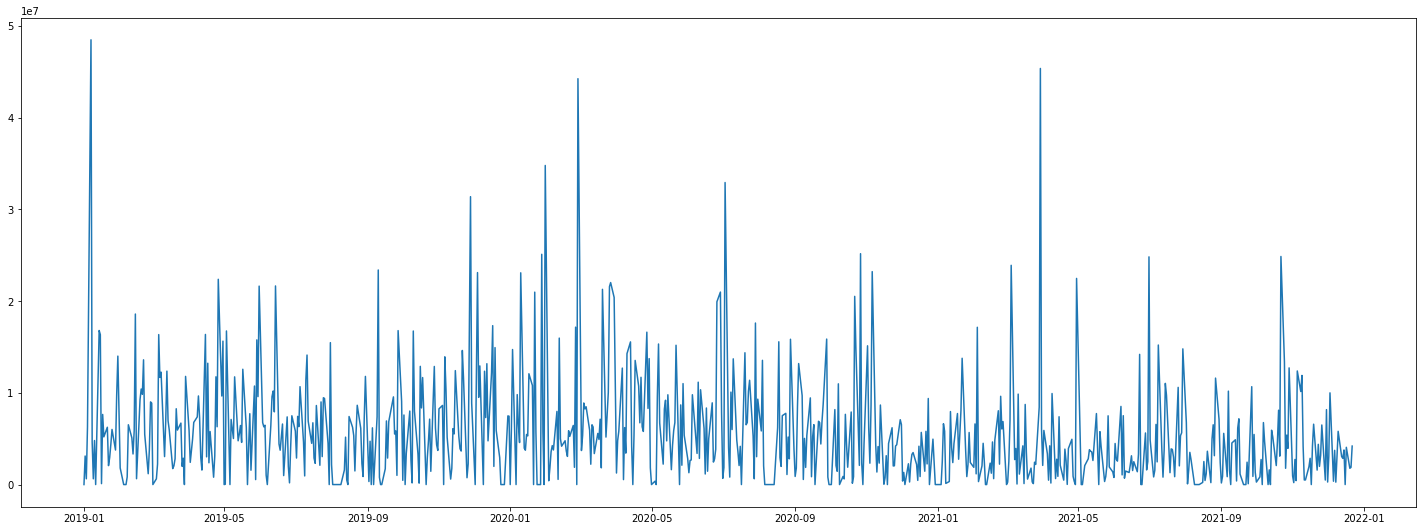

In [12]:
plt.figure(figsize = (25, 9))
plt.plot(df_1110.index,df_1110.y)
plt.show()

In [13]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1110)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,cap,floor
781,2021-12-27,25000000,0
782,2021-12-28,25000000,0
783,2021-12-29,25000000,0
784,2021-12-30,25000000,0
785,2021-12-31,25000000,0


In [14]:
forecast=m.predict(future)
preds= forecast['yhat'][:-7]

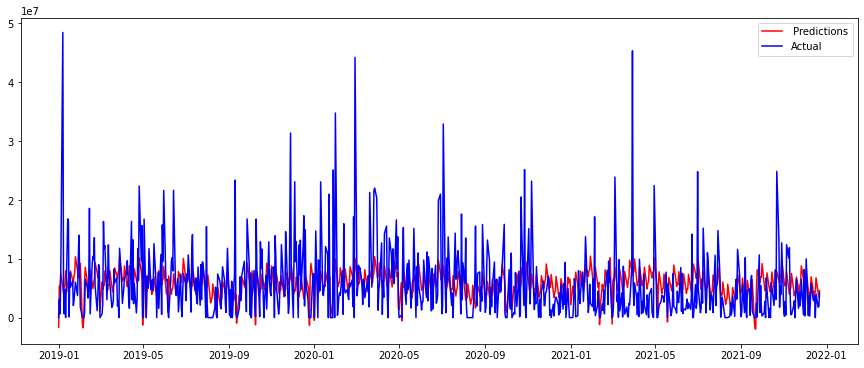

In [15]:
plt.figure(figsize=(15,6))
plt.plot(df_1110.index,preds,color='red',label=' Predictions')
plt.plot(df_1110.index,df_1110.y,color='blue',label='Actual')
plt.legend()
plt.show()

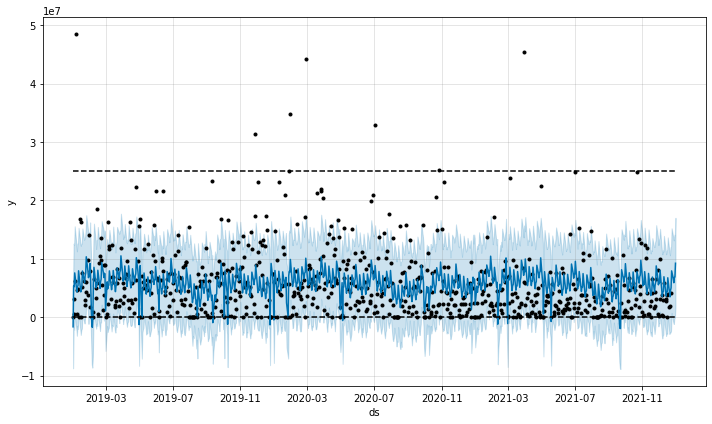

In [16]:
fig = m.plot(m.predict(future))

In [17]:
r2 = round(r2_score(df_1110["y"], preds), 3)
mse = round(mean_squared_error(df_1110["y"], preds), 3)
mae = round(mean_absolute_error(df_1110["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.111
MSE:  31312310608463.93
MAE:  3927721.745


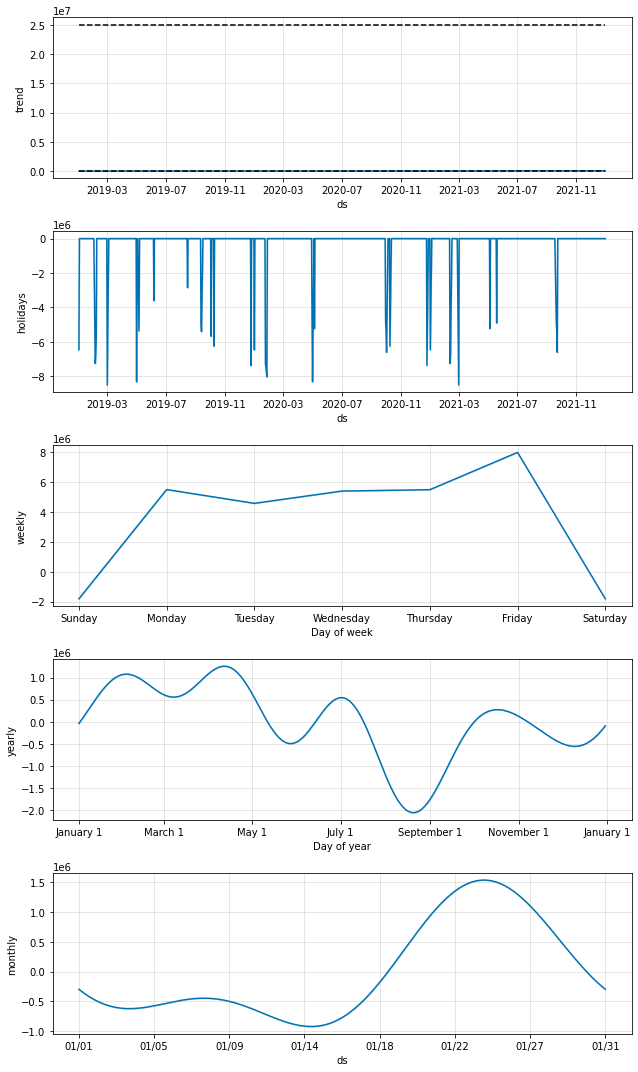

In [18]:
fig = m.plot_components(forecast)

In [19]:
forecast.tail()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
779,2021-12-27,60236.871679,25000000,0,-3.643268e+05,1.393899e+07,60236.871679,60236.871679,0.0,0.0,...,5.510173e+06,5.510173e+06,5.510173e+06,-248798.295335,-248798.295335,-248798.295335,0.0,0.0,0.0,6.606223e+06
780,2021-12-28,60412.292800,25000000,0,-1.333583e+06,1.280111e+07,60412.292800,60412.292800,0.0,0.0,...,4.584945e+06,4.584945e+06,4.584945e+06,-212056.692876,-212056.692876,-212056.692876,0.0,0.0,0.0,5.907093e+06
781,2021-12-29,60588.223539,25000000,0,-8.034344e+05,1.398315e+07,60588.223539,60588.223539,0.0,0.0,...,5.409090e+06,5.409090e+06,5.409090e+06,-173587.312730,-173587.312730,-173587.312730,0.0,0.0,0.0,6.832374e+06
782,2021-12-30,60764.665370,25000000,0,-3.096314e+05,1.369965e+07,60764.665370,60764.665370,0.0,0.0,...,5.500634e+06,5.500634e+06,5.500634e+06,-133497.685225,-133497.685225,-133497.685225,0.0,0.0,0.0,6.894974e+06
783,2021-12-31,60941.619770,25000000,0,1.945039e+06,1.646222e+07,60941.619770,60941.619770,0.0,0.0,...,7.998790e+06,7.998790e+06,7.998790e+06,-91905.464580,-91905.464580,-91905.464580,0.0,0.0,0.0,9.245717e+06


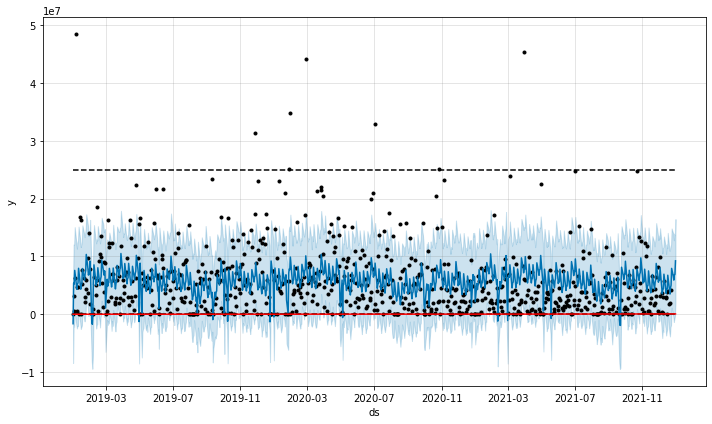

In [20]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [21]:
  pd.options.display.float_format = '{:,.0f}'.format

In [22]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 3,492,412  -3,841,879  11,037,768
776 2021-12-22 4,585,640  -2,207,885  11,786,573
777 2021-12-23 5,031,169  -1,861,441  12,047,487
778 2021-12-24 7,939,197   1,140,494  14,847,184
779 2021-12-27 6,606,223    -364,327  13,938,993
780 2021-12-28 5,907,093  -1,333,583  12,801,105
781 2021-12-29 6,832,374    -803,434  13,983,147
782 2021-12-30 6,894,974    -309,631  13,699,647
783 2021-12-31 9,245,717   1,945,039  16,462,218


In [23]:
final_1110 = forecast[['ds', 'yhat']]
final_1110['yhat_1110'] = final_1110['yhat']
final_1110 = final_1110[['ds', 'yhat_1110']]

In [24]:
final_1110.tail()

,ds,yhat_1110
779,2021-12-27,"6,606,223"
780,2021-12-28,"5,907,093"
781,2021-12-29,"6,832,374"
782,2021-12-30,"6,894,974"
783,2021-12-31,"9,245,717"


In [25]:
#Ansung
df_1120 = df[['date','1120']]
df_1120['ds'] = pd.to_datetime(df_1120['date'])
df_1120['y'] = df_1120['1120']
df_1120 = df_1120.loc[:,['ds', 'y']]
df_1120.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,459470
2,2019-01-03,921500
3,2019-01-04,256950
4,2019-01-05,0


In [26]:
df_1120['ds'] = pd.to_datetime(df_1120['ds'])
df_1120 = df_1120[df_1120['ds'].dt.dayofweek < 5]
df_1120['date_index'] = df_1120['ds']
df_1120 = df_1120.set_index('date_index')
df_1120['cap'] = 30000000
df_1120['floor'] = 0
df_1120.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,459470,30000000,0
2019-01-03,2019-01-03,921500,30000000,0
2019-01-04,2019-01-04,256950,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,59080,30000000,0
2019-01-09,2019-01-09,247650,30000000,0
2019-01-10,2019-01-10,196300,30000000,0
2019-01-11,2019-01-11,1889730,30000000,0


In [27]:
from datetime import datetime
df_1120 = df_1120[datetime(2019, 1, 1):datetime(2021, 12, 22)]

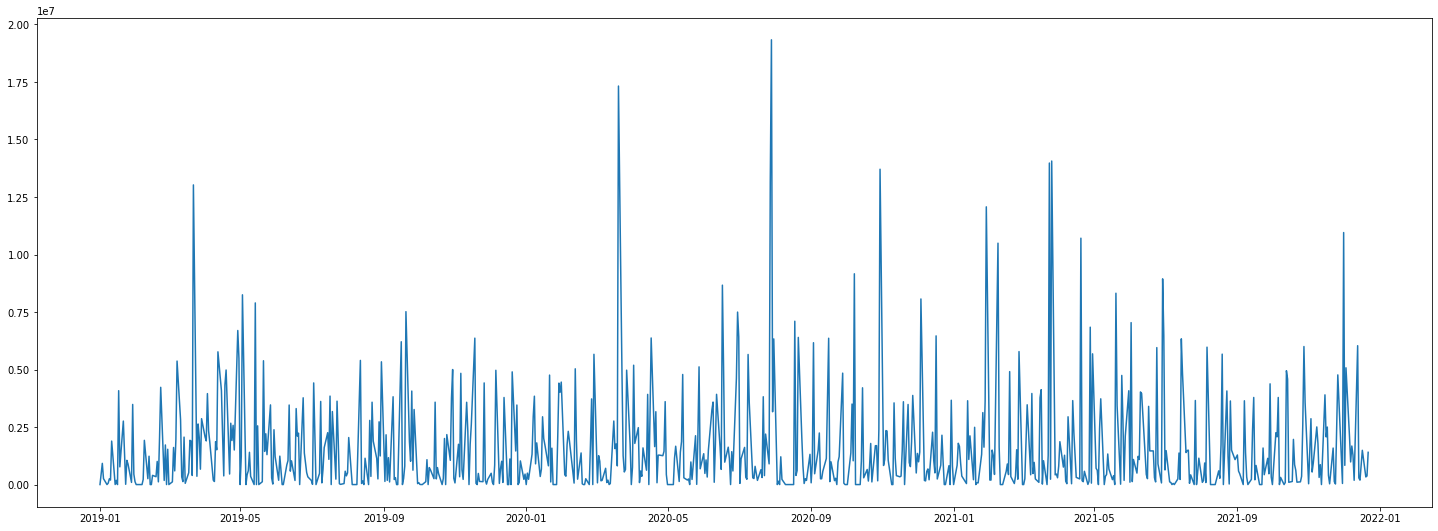

In [28]:
plt.figure(figsize = (25, 9))
plt.plot(df_1120.index,df_1120.y)
plt.show()

In [29]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1120)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 10000000
future['floor'] = 0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
forecast=m.predict(future)
forecast.tail(10)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"154,611",10000000,0,"-1,966,501","3,754,796","154,611","154,611",0,0,...,"1,017,405","1,017,405","1,017,405","-342,652","-342,652","-342,652",0,0,0,"841,319"
775,2021-12-21,"154,873",10000000,0,"-1,812,333","4,069,745","154,873","154,873",0,0,...,"1,410,972","1,410,972","1,410,972","-343,739","-343,739","-343,739",0,0,0,"1,203,321"
776,2021-12-22,"155,135",10000000,0,"-1,387,478","4,255,686","155,135","155,135",0,0,...,"1,561,105","1,561,105","1,561,105","-343,807","-343,807","-343,807",0,0,0,"1,346,250"
777,2021-12-23,"155,397",10000000,0,"-1,459,468","4,052,122","155,397","155,397",0,0,...,"1,389,600","1,389,600","1,389,600","-342,869","-342,869","-342,869",0,0,0,"1,201,544"
778,2021-12-24,"155,660",10000000,0,"-1,095,569","4,899,638","155,660","155,660",0,0,...,"1,947,703","1,947,703","1,947,703","-340,945","-340,945","-340,945",0,0,0,"1,823,353"
779,2021-12-27,"156,451",10000000,0,"-1,638,555","4,181,959","156,451","156,451",0,0,...,"1,017,405","1,017,405","1,017,405","-329,562","-329,562","-329,562",0,0,0,"1,226,060"
780,2021-12-28,"156,716",10000000,0,"-984,451","4,587,174","156,716","156,716",0,0,...,"1,410,972","1,410,972","1,410,972","-324,033","-324,033","-324,033",0,0,0,"1,724,446"
781,2021-12-29,"156,981",10000000,0,"-725,537","4,966,830","156,981","156,981",0,0,...,"1,561,105","1,561,105","1,561,105","-317,721","-317,721","-317,721",0,0,0,"1,945,189"
782,2021-12-30,"157,246",10000000,0,"-922,784","4,659,705","157,246","157,246",0,0,...,"1,389,600","1,389,600","1,389,600","-310,683","-310,683","-310,683",0,0,0,"1,795,387"
783,2021-12-31,"157,512",10000000,0,"-379,022","5,075,517","157,512","157,512",0,0,...,"1,947,703","1,947,703","1,947,703","-302,984","-302,984","-302,984",0,0,0,"2,318,132"


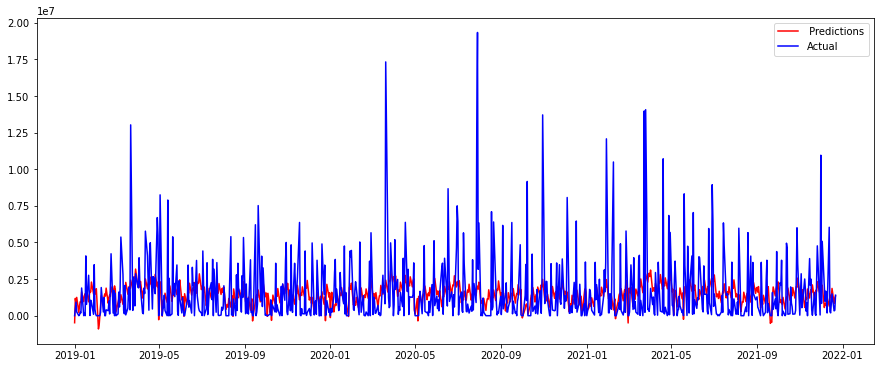

In [31]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1120.index,preds,color='red',label=' Predictions')
plt.plot(df_1120.index,df_1120.y,color='blue',label='Actual')
plt.legend()
plt.show()

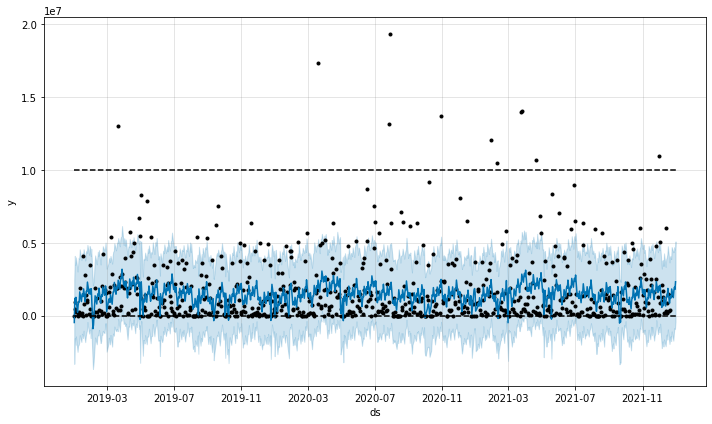

In [32]:
fig = m.plot(m.predict(future))

In [33]:
r2 = round(r2_score(df_1120["y"], preds), 3)
mse = round(mean_squared_error(df_1120["y"], preds), 3)
mae = round(mean_absolute_error(df_1120["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.071
MSE:  4873161791000.625
MAE:  1440373.798


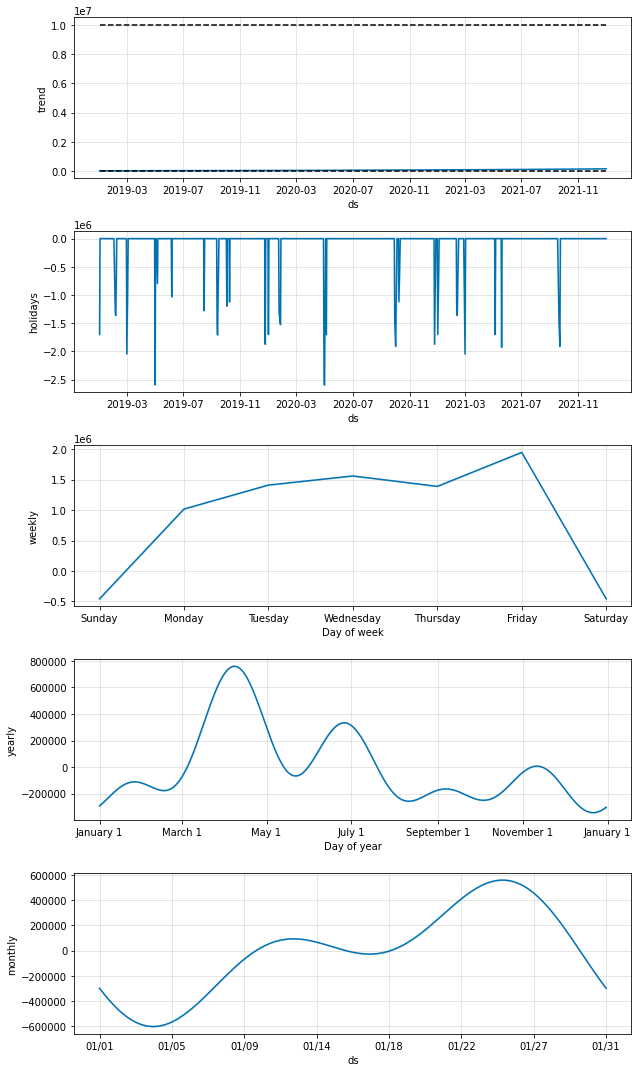

In [34]:
fig = m.plot_components(forecast)

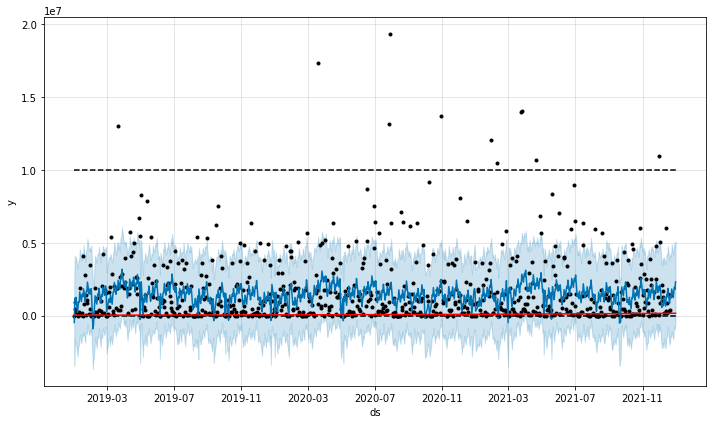

In [35]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [36]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 1,203,321  -1,812,333   4,069,745
776 2021-12-22 1,346,250  -1,387,478   4,255,686
777 2021-12-23 1,201,544  -1,459,468   4,052,122
778 2021-12-24 1,823,353  -1,095,569   4,899,638
779 2021-12-27 1,226,060  -1,638,555   4,181,959
780 2021-12-28 1,724,446    -984,451   4,587,174
781 2021-12-29 1,945,189    -725,537   4,966,830
782 2021-12-30 1,795,387    -922,784   4,659,705
783 2021-12-31 2,318,132    -379,022   5,075,517


In [37]:
final_1120 = forecast[['ds', 'yhat']]
final_1120['yhat_1120'] = final_1120['yhat']
final_1120 = final_1120[['ds', 'yhat_1120']]
final_1120.tail()

,ds,yhat_1120
779,2021-12-27,"1,226,060"
780,2021-12-28,"1,724,446"
781,2021-12-29,"1,945,189"
782,2021-12-30,"1,795,387"
783,2021-12-31,"2,318,132"


In [38]:
#Asan
df_1140 = df[['date','1140']]
df_1140['ds'] = pd.to_datetime(df_1140['date'])
df_1140['y'] = df_1140['1140']
df_1140 = df_1140.loc[:,['ds', 'y']]
df_1140.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,463200
2,2019-01-03,1708000
3,2019-01-04,272500
4,2019-01-05,0


In [39]:
df_1140['ds'] = pd.to_datetime(df_1140['ds'])
df_1140 = df_1140[df_1140['ds'].dt.dayofweek < 5]
df_1140['date_index'] = df_1140['ds']
df_1140 = df_1140.set_index('date_index')
df_1140['cap'] = 30000000
df_1140['floor'] = 0
df_1140.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,463200,30000000,0
2019-01-03,2019-01-03,1708000,30000000,0
2019-01-04,2019-01-04,272500,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,3764000,30000000,0
2019-01-09,2019-01-09,2679690,30000000,0
2019-01-10,2019-01-10,3392000,30000000,0
2019-01-11,2019-01-11,485000,30000000,0


In [40]:
from datetime import datetime
df_1140 = df_1140[datetime(2019, 1, 1):datetime(2021, 12, 22)]

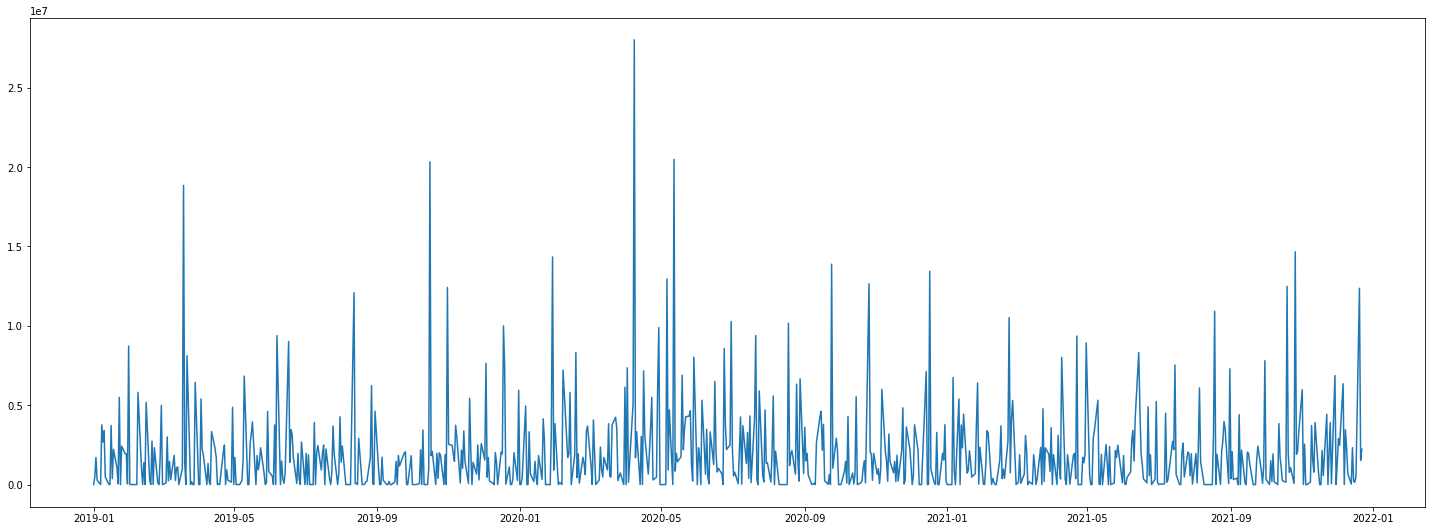

In [41]:
plt.figure(figsize = (25, 9))
plt.plot(df_1140.index,df_1140.y)
plt.show()

In [42]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1140)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 15000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"138,290",15000000,0,"-2,116,834","4,948,918","138,290","138,290",0,0,...,"1,332,536","1,332,536","1,332,536","-155,213","-155,213","-155,213",0,0,0,"1,446,453"
775,2021-12-21,"138,595",15000000,0,"-1,129,432","5,914,286","138,595","138,595",0,0,...,"2,372,609","2,372,609","2,372,609","-145,770","-145,770","-145,770",0,0,0,"2,474,993"
776,2021-12-22,"138,900",15000000,0,"-1,461,627","5,636,655","138,900","138,900",0,0,...,"2,056,300","2,056,300","2,056,300","-135,682","-135,682","-135,682",0,0,0,"2,151,690"
777,2021-12-23,"139,206",15000000,0,"-1,707,174","5,585,549","139,206","139,206",0,0,...,"1,920,247","1,920,247","1,920,247","-125,015","-125,015","-125,015",0,0,0,"2,018,542"
778,2021-12-24,"139,513",15000000,0,"-1,558,257","5,845,101","139,513","139,513",0,0,...,"1,864,062","1,864,062","1,864,062","-113,837","-113,837","-113,837",0,0,0,"1,977,916"
779,2021-12-27,"140,436",15000000,0,"-2,034,329","4,981,311","140,436","140,436",0,0,...,"1,332,536","1,332,536","1,332,536","-77,960","-77,960","-77,960",0,0,0,"1,550,159"
780,2021-12-28,"140,745",15000000,0,"-1,083,941","6,275,596","140,745","140,745",0,0,...,"2,372,609","2,372,609","2,372,609","-65,472","-65,472","-65,472",0,0,0,"2,624,938"
781,2021-12-29,"141,055",15000000,0,"-860,870","5,940,831","141,055","141,055",0,0,...,"2,056,300","2,056,300","2,056,300","-52,848","-52,848","-52,848",0,0,0,"2,331,177"
782,2021-12-30,"141,366",15000000,0,"-1,381,140","5,912,730","141,366","141,366",0,0,...,"1,920,247","1,920,247","1,920,247","-40,167","-40,167","-40,167",0,0,0,"2,199,333"
783,2021-12-31,"141,677",15000000,0,"-1,315,022","5,612,011","141,677","141,677",0,0,...,"1,864,062","1,864,062","1,864,062","-27,508","-27,508","-27,508",0,0,0,"2,125,376"


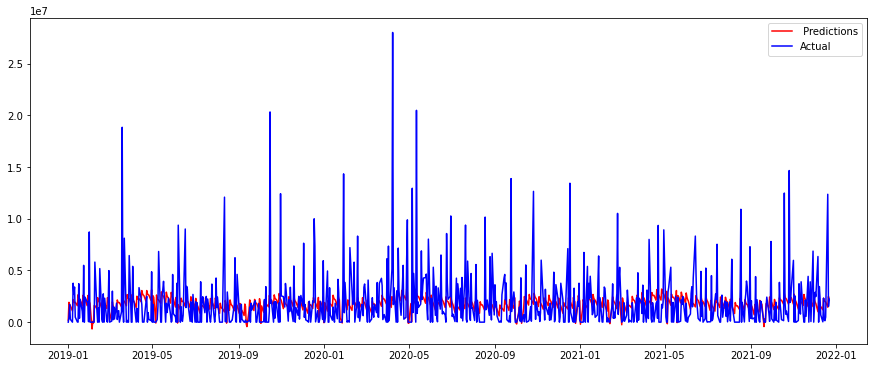

In [43]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1140.index,preds,color='red',label=' Predictions')
plt.plot(df_1140.index,df_1140.y,color='blue',label='Actual')
plt.legend()
plt.show()

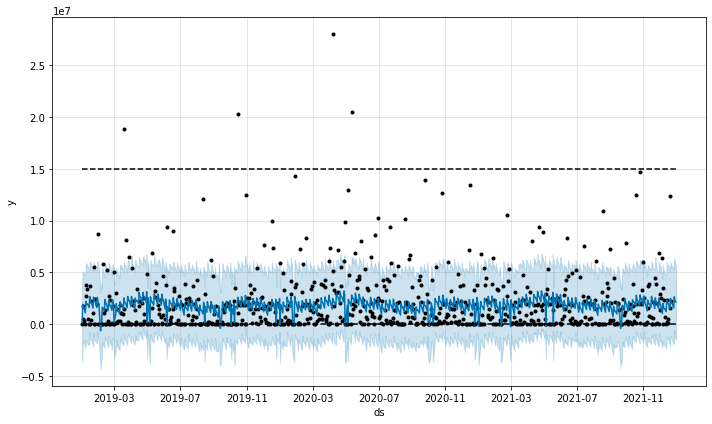

In [44]:
fig = m.plot(m.predict(future))

In [45]:
r2 = round(r2_score(df_1140["y"], preds), 3)
mse = round(mean_squared_error(df_1140["y"], preds), 3)
mae = round(mean_absolute_error(df_1140["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.047
MSE:  7711141083754.969
MAE:  1760203.679


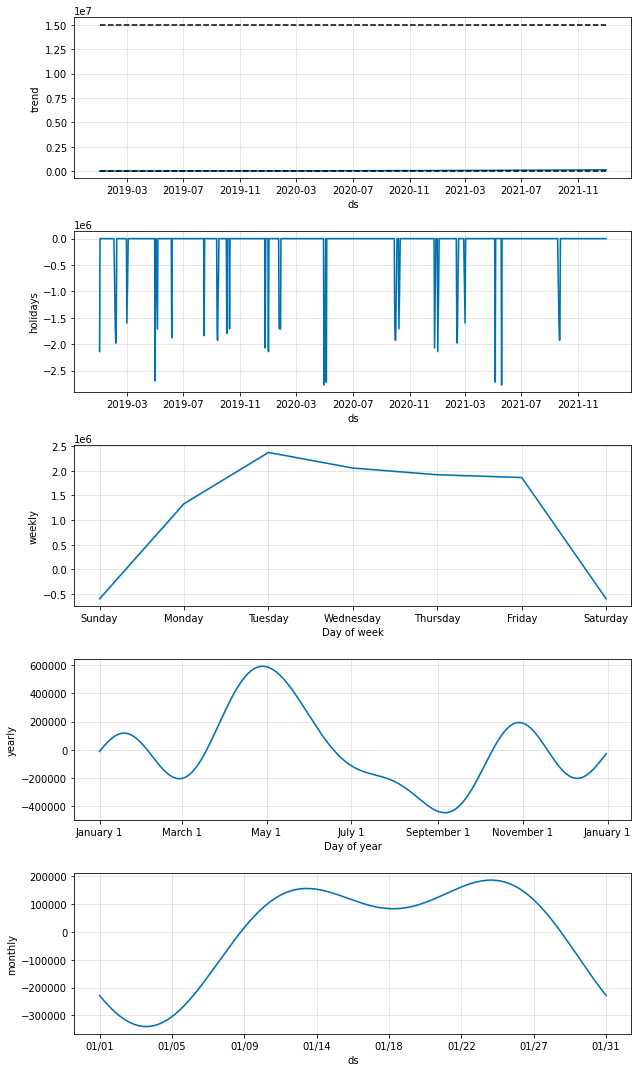

In [46]:
fig = m.plot_components(forecast)

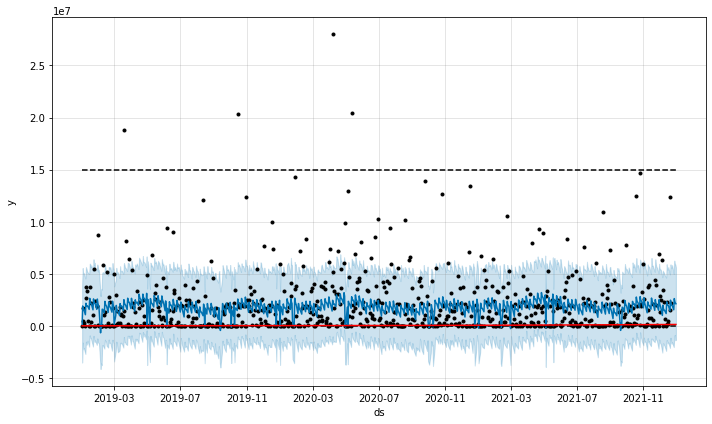

In [47]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [48]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 2,474,993  -1,129,432   5,914,286
776 2021-12-22 2,151,690  -1,461,627   5,636,655
777 2021-12-23 2,018,542  -1,707,174   5,585,549
778 2021-12-24 1,977,916  -1,558,257   5,845,101
779 2021-12-27 1,550,159  -2,034,329   4,981,311
780 2021-12-28 2,624,938  -1,083,941   6,275,596
781 2021-12-29 2,331,177    -860,870   5,940,831
782 2021-12-30 2,199,333  -1,381,140   5,912,730
783 2021-12-31 2,125,376  -1,315,022   5,612,011


In [49]:
final_1140 = forecast[['ds', 'yhat']]
final_1140['yhat_1140'] = final_1140['yhat']
final_1140 = final_1140[['ds', 'yhat_1140']]
final_1140.head()

,ds,yhat_1140
0,2019-01-01,"164,687"
1,2019-01-02,"1,914,949"
2,2019-01-03,"1,711,228"
3,2019-01-04,"1,603,809"
4,2019-01-07,"1,078,376"


In [50]:
#Poseung
df_1150 = df[['date','1150']]
df_1150['ds'] = pd.to_datetime(df_1150['date'])
df_1150['y'] = df_1150['1150']
df_1150 = df_1150.loc[:,['ds', 'y']]
df_1150.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,0
2,2019-01-03,0
3,2019-01-04,0
4,2019-01-05,0


In [51]:
df_1150['ds'] = pd.to_datetime(df_1150['ds'])
df_1150 = df_1150[df_1150['ds'].dt.dayofweek < 5]
df_1150['date_index'] = df_1150['ds']
df_1150 = df_1150.set_index('date_index')
df_1150['cap'] = 30000000
df_1150['floor'] = 0
df_1150.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,0,30000000,0
2019-01-03,2019-01-03,0,30000000,0
2019-01-04,2019-01-04,0,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,0,30000000,0
2019-01-09,2019-01-09,0,30000000,0
2019-01-10,2019-01-10,0,30000000,0
2019-01-11,2019-01-11,0,30000000,0


In [52]:
from datetime import datetime
df_1150 = df_1150[datetime(2019, 1, 1):datetime(2021, 12, 22)]

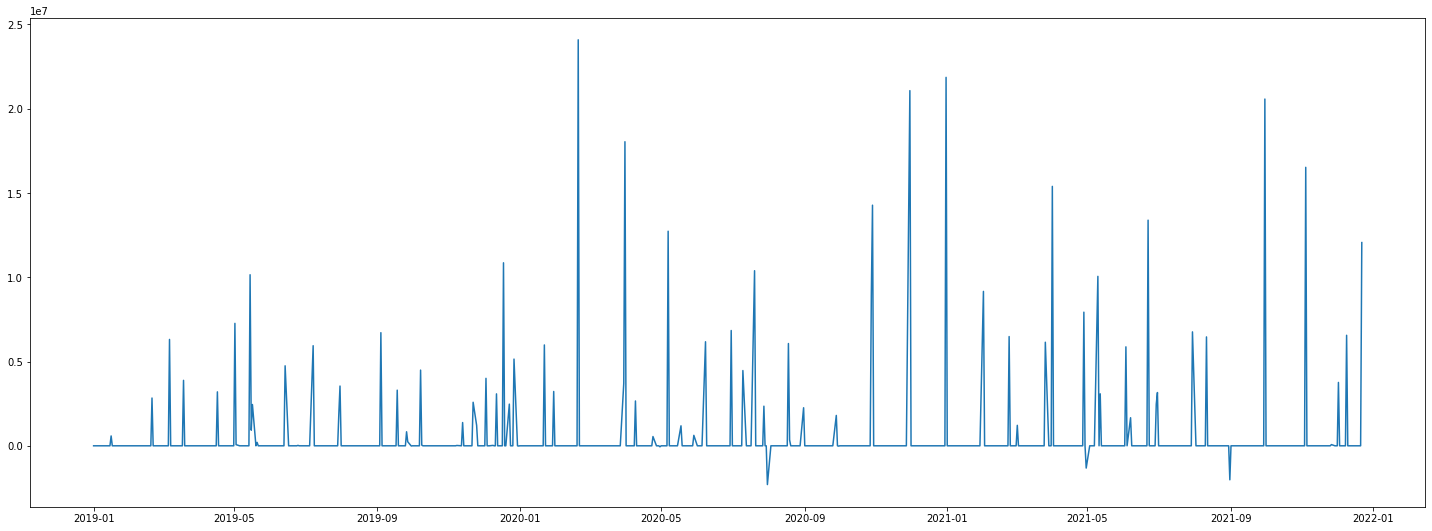

In [53]:
plt.figure(figsize = (25, 9))
plt.plot(df_1150.index,df_1150.y)
plt.show()

In [54]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1150)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 15000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"209,502",15000000,0,"-2,103,175","4,172,999","209,502","209,502",0,0,...,"427,358","427,358","427,358","451,252","451,252","451,252",0,0,0,"988,137"
775,2021-12-21,"210,313",15000000,0,"-2,362,553","3,938,765","210,313","210,313",0,0,...,"366,020","366,020","366,020","446,270","446,270","446,270",0,0,0,"903,301"
776,2021-12-22,"211,127",15000000,0,"-2,288,003","3,951,398","211,127","211,127",0,0,...,"529,784","529,784","529,784","439,567","439,567","439,567",0,0,0,"1,042,407"
777,2021-12-23,"211,943",15000000,0,"-1,491,924","4,557,015","211,943","211,943",0,0,...,"1,015,390","1,015,390","1,015,390","431,183","431,183","431,183",0,0,0,"1,514,874"
778,2021-12-24,"212,763",15000000,0,"-2,382,660","3,794,653","212,763","212,763",0,0,...,"139,970","139,970","139,970","421,172","421,172","421,172",0,0,0,"648,732"
779,2021-12-27,"215,242",15000000,0,"-2,038,709","4,357,725","215,242","215,242",0,0,...,"427,358","427,358","427,358","382,035","382,035","382,035",0,0,0,"1,138,801"
780,2021-12-28,"216,074",15000000,0,"-1,880,631","4,242,290","216,074","216,074",0,0,...,"366,020","366,020","366,020","366,219","366,219","366,219",0,0,0,"1,187,516"
781,2021-12-29,"216,910",15000000,0,"-1,817,476","4,647,161","216,910","216,910",0,0,...,"529,784","529,784","529,784","349,170","349,170","349,170",0,0,0,"1,461,615"
782,2021-12-30,"217,748",15000000,0,"-895,130","5,383,659","217,748","217,748",0,0,...,"1,015,390","1,015,390","1,015,390","330,991","330,991","330,991",0,0,0,"2,040,987"
783,2021-12-31,"218,590",15000000,0,"-1,850,363","4,408,075","218,590","218,590",0,0,...,"139,970","139,970","139,970","311,790","311,790","311,790",0,0,0,"1,226,566"


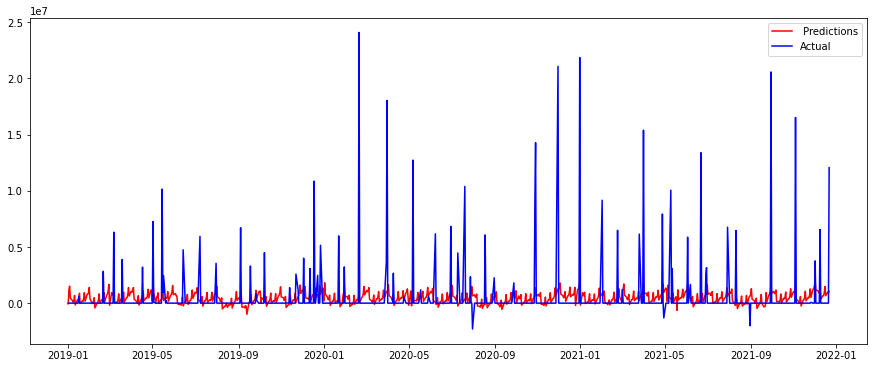

In [55]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1150.index,preds,color='red',label=' Predictions')
plt.plot(df_1150.index,df_1150.y,color='blue',label='Actual')
plt.legend()
plt.show()

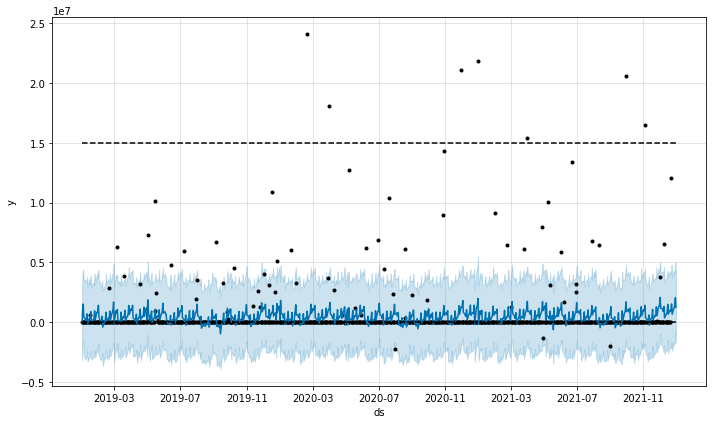

In [56]:
fig = m.plot(m.predict(future))

In [57]:
r2 = round(r2_score(df_1150["y"], preds), 3)
mse = round(mean_squared_error(df_1150["y"], preds), 3)
mae = round(mean_absolute_error(df_1150["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.038
MSE:  5871929116992.682
MAE:  1002335.31


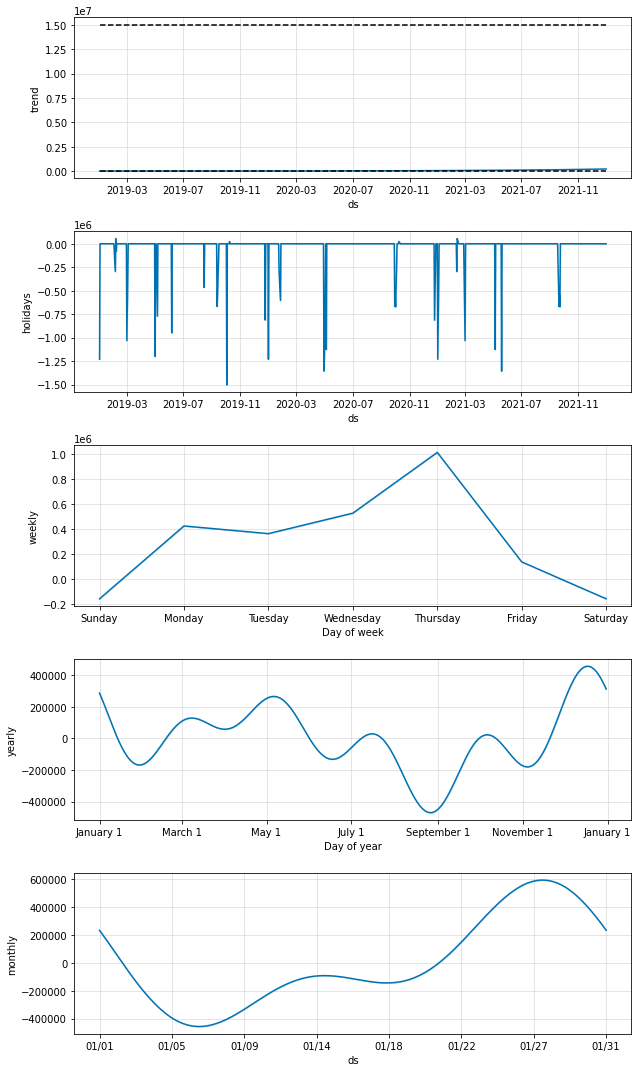

In [58]:
fig = m.plot_components(forecast)

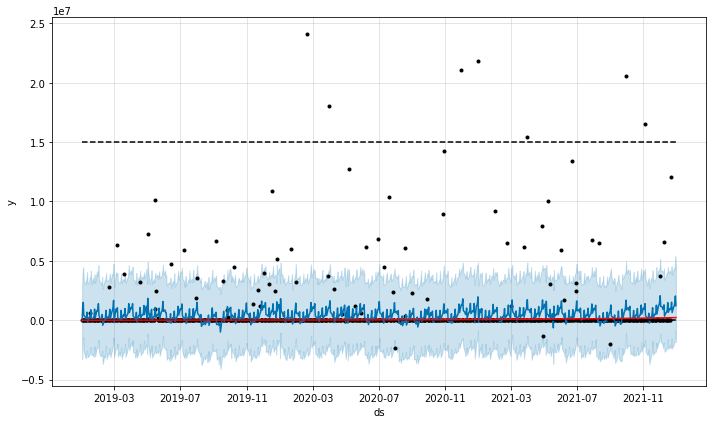

In [59]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [60]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21   903,301  -2,362,553   3,938,765
776 2021-12-22 1,042,407  -2,288,003   3,951,398
777 2021-12-23 1,514,874  -1,491,924   4,557,015
778 2021-12-24   648,732  -2,382,660   3,794,653
779 2021-12-27 1,138,801  -2,038,709   4,357,725
780 2021-12-28 1,187,516  -1,880,631   4,242,290
781 2021-12-29 1,461,615  -1,817,476   4,647,161
782 2021-12-30 2,040,987    -895,130   5,383,659
783 2021-12-31 1,226,566  -1,850,363   4,408,075


In [61]:
final_1150 = forecast[['ds', 'yhat']]
final_1150['yhat_1150'] = final_1150['yhat']
final_1150 = final_1150[['ds', 'yhat_1150']]
final_1150.head()

,ds,yhat_1150
0,2019-01-01,"-61,247"
1,2019-01-02,"1,193,331"
2,2019-01-03,"1,505,552"
3,2019-01-04,"438,938"
4,2019-01-07,"230,423"


In [62]:
#GUMI
df_1160 = df[['date','1160']]
df_1160['ds'] = pd.to_datetime(df_1160['date'])
df_1160['y'] = df_1160['1160']
df_1160 = df_1160.loc[:,['ds', 'y']]
df_1160.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,48360
2,2019-01-03,807270
3,2019-01-04,901000
4,2019-01-05,0


In [63]:
df_1160['ds'] = pd.to_datetime(df_1160['ds'])
df_1160 = df_1160[df_1160['ds'].dt.dayofweek < 5]
df_1160['date_index'] = df_1160['ds']
df_1160 = df_1160.set_index('date_index')
df_1160['cap'] = 30000000
df_1160['floor'] = 0
df_1160.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,48360,30000000,0
2019-01-03,2019-01-03,807270,30000000,0
2019-01-04,2019-01-04,901000,30000000,0
2019-01-07,2019-01-07,829200,30000000,0
2019-01-08,2019-01-08,1238550,30000000,0
2019-01-09,2019-01-09,2607400,30000000,0
2019-01-10,2019-01-10,306300,30000000,0
2019-01-11,2019-01-11,971800,30000000,0


In [64]:
from datetime import datetime
df_1160 = df_1160[datetime(2019, 1, 1):datetime(2021, 12, 22)]

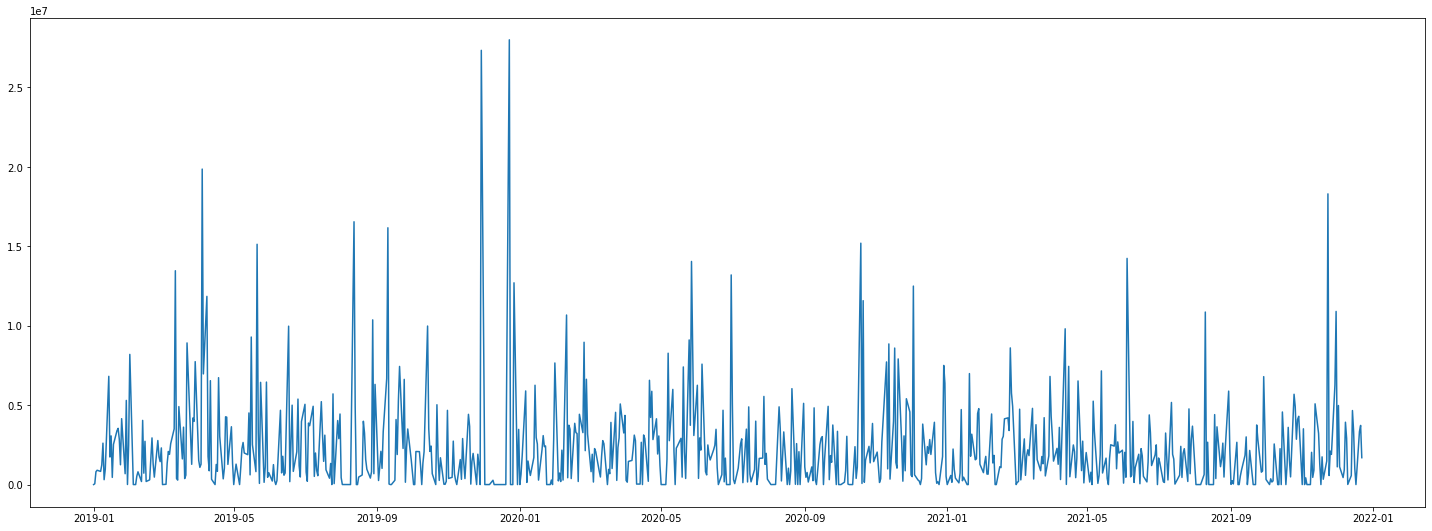

In [65]:
plt.figure(figsize = (25, 9))
plt.plot(df_1160.index,df_1160.y)
plt.show()

In [66]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1160)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 15000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"55,569",15000000,0,"-1,222,262","6,043,647","55,569","55,569",0,0,...,"2,535,393","2,535,393","2,535,393","40,467","40,467","40,467",0,0,0,"2,500,261"
775,2021-12-21,"55,689",15000000,0,"-1,109,424","6,127,441","55,689","55,689",0,0,...,"2,514,336","2,514,336","2,514,336","23,999","23,999","23,999",0,0,0,"2,580,431"
776,2021-12-22,"55,810",15000000,0,"-1,607,349","5,928,962","55,810","55,810",0,0,...,"2,064,063","2,064,063","2,064,063","7,822","7,822","7,822",0,0,0,"2,281,424"
777,2021-12-23,"55,931",15000000,0,"-1,156,953","6,178,028","55,931","55,931",0,0,...,"2,250,796","2,250,796","2,250,796","-8,000","-8,000","-8,000",0,0,0,"2,650,700"
778,2021-12-24,"56,052",15000000,0,"-513,512","6,978,577","56,052","56,052",0,0,...,"2,323,720","2,323,720","2,323,720","-23,402","-23,402","-23,402",0,0,0,"2,911,108"
779,2021-12-27,"56,417",15000000,0,"-44,991","6,885,781","56,417","56,417",0,0,...,"2,535,393","2,535,393","2,535,393","-66,525","-66,525","-66,525",0,0,0,"3,428,705"
780,2021-12-28,"56,539",15000000,0,"-429,143","7,236,762","56,539","56,539",0,0,...,"2,514,336","2,514,336","2,514,336","-79,701","-79,701","-79,701",0,0,0,"3,353,545"
781,2021-12-29,"56,662",15000000,0,"-724,675","6,221,075","56,662","56,662",0,0,...,"2,064,063","2,064,063","2,064,063","-92,204","-92,204","-92,204",0,0,0,"2,760,966"
782,2021-12-30,"56,785",15000000,0,"-975,099","6,349,862","56,785","56,785",0,0,...,"2,250,796","2,250,796","2,250,796","-103,995","-103,995","-103,995",0,0,0,"2,729,479"
783,2021-12-31,"56,908",15000000,0,"-1,134,935","6,181,803","56,908","56,908",0,0,...,"2,323,720","2,323,720","2,323,720","-115,043","-115,043","-115,043",0,0,0,"2,531,429"


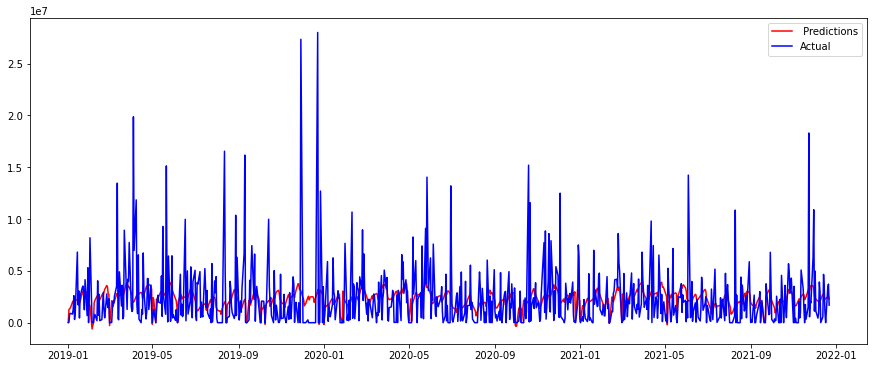

In [67]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1160.index,preds,color='red',label=' Predictions')
plt.plot(df_1160.index,df_1160.y,color='blue',label='Actual')
plt.legend()
plt.show()

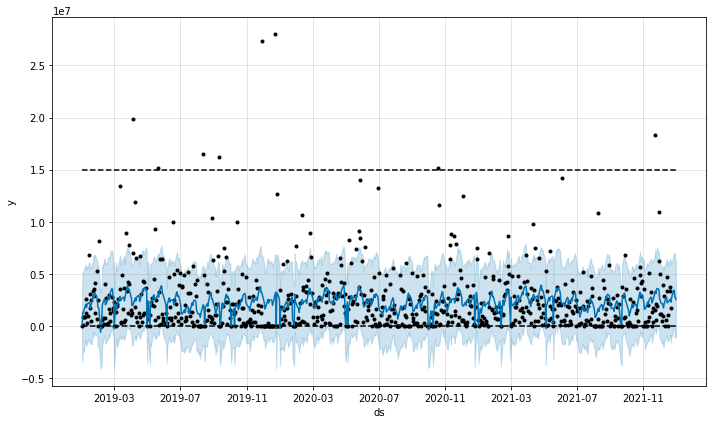

In [68]:
fig = m.plot(m.predict(future))

In [69]:
r2 = round(r2_score(df_1160["y"], preds), 3)
mse = round(mean_squared_error(df_1160["y"], preds), 3)
mae = round(mean_absolute_error(df_1160["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.067
MSE:  8470062792424.838
MAE:  1864436.019


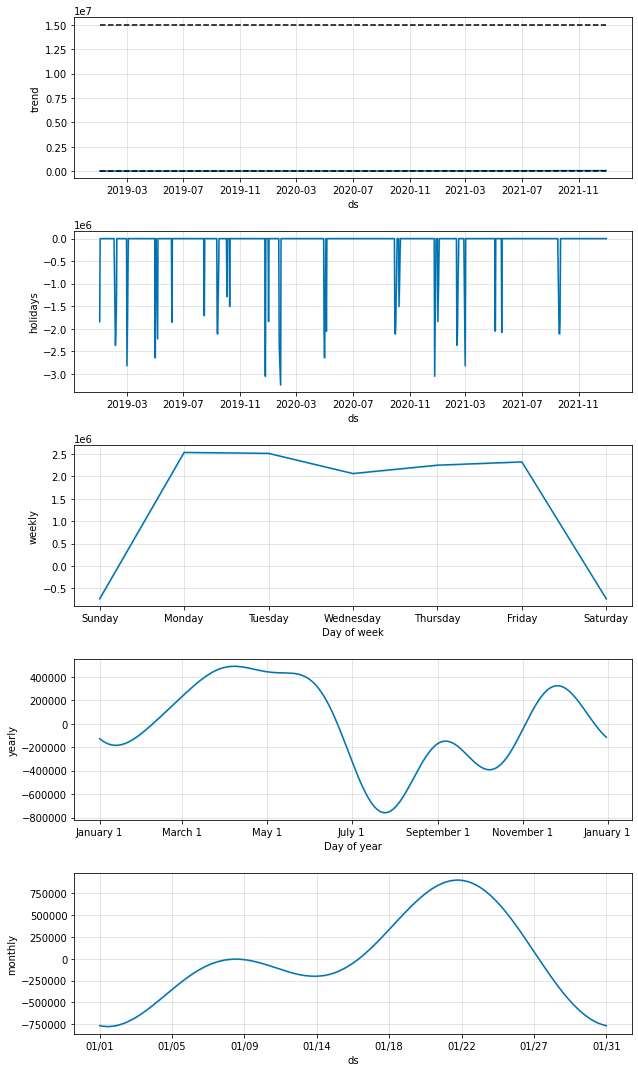

In [70]:
fig = m.plot_components(forecast)

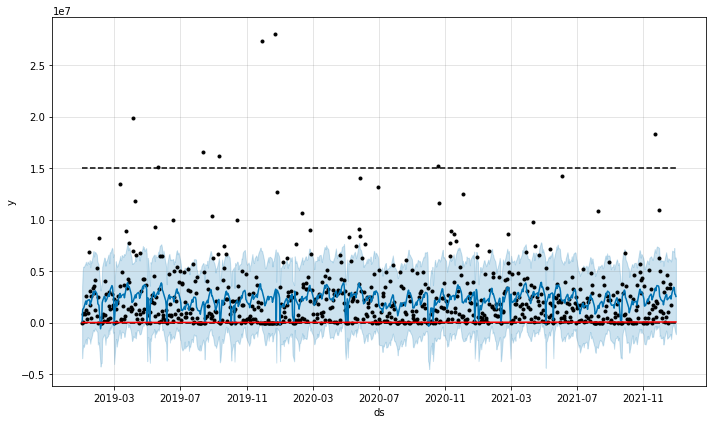

In [71]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [72]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 2,580,431  -1,109,424   6,127,441
776 2021-12-22 2,281,424  -1,607,349   5,928,962
777 2021-12-23 2,650,700  -1,156,953   6,178,028
778 2021-12-24 2,911,108    -513,512   6,978,577
779 2021-12-27 3,428,705     -44,991   6,885,781
780 2021-12-28 3,353,545    -429,143   7,236,762
781 2021-12-29 2,760,966    -724,675   6,221,075
782 2021-12-30 2,729,479    -975,099   6,349,862
783 2021-12-31 2,531,429  -1,134,935   6,181,803


In [73]:
final_1160 = forecast[['ds', 'yhat']]
final_1160['yhat_1160'] = final_1160['yhat']
final_1160 = final_1160[['ds', 'yhat_1160']]
final_1160.head()

,ds,yhat_1160
0,2019-01-01,"38,138"
1,2019-01-02,"1,253,936"
2,2019-01-03,"1,349,452"
3,2019-01-04,"1,415,223"
4,2019-01-07,"1,965,047"


In [74]:
#Pusan
df_1170 = df[['date','1170']]
df_1170['ds'] = pd.to_datetime(df_1170['date'])
df_1170['y'] = df_1170['1170']
df_1170 = df_1170.loc[:,['ds', 'y']]
df_1170.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,376880
2,2019-01-03,1125000
3,2019-01-04,0
4,2019-01-05,0


In [75]:
df_1170['ds'] = pd.to_datetime(df_1170['ds'])
df_1170 = df_1170[df_1170['ds'].dt.dayofweek < 5]
df_1170['date_index'] = df_1170['ds']
df_1170 = df_1170.set_index('date_index')
df_1170['cap'] = 30000000
df_1170['floor'] = 0
df_1170.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,376880,30000000,0
2019-01-03,2019-01-03,1125000,30000000,0
2019-01-04,2019-01-04,0,30000000,0
2019-01-07,2019-01-07,1756570,30000000,0
2019-01-08,2019-01-08,1919400,30000000,0
2019-01-09,2019-01-09,712250,30000000,0
2019-01-10,2019-01-10,938000,30000000,0
2019-01-11,2019-01-11,0,30000000,0


In [76]:
from datetime import datetime
df_1170 = df_1170[datetime(2019, 1, 1):datetime(2021, 12, 22)]

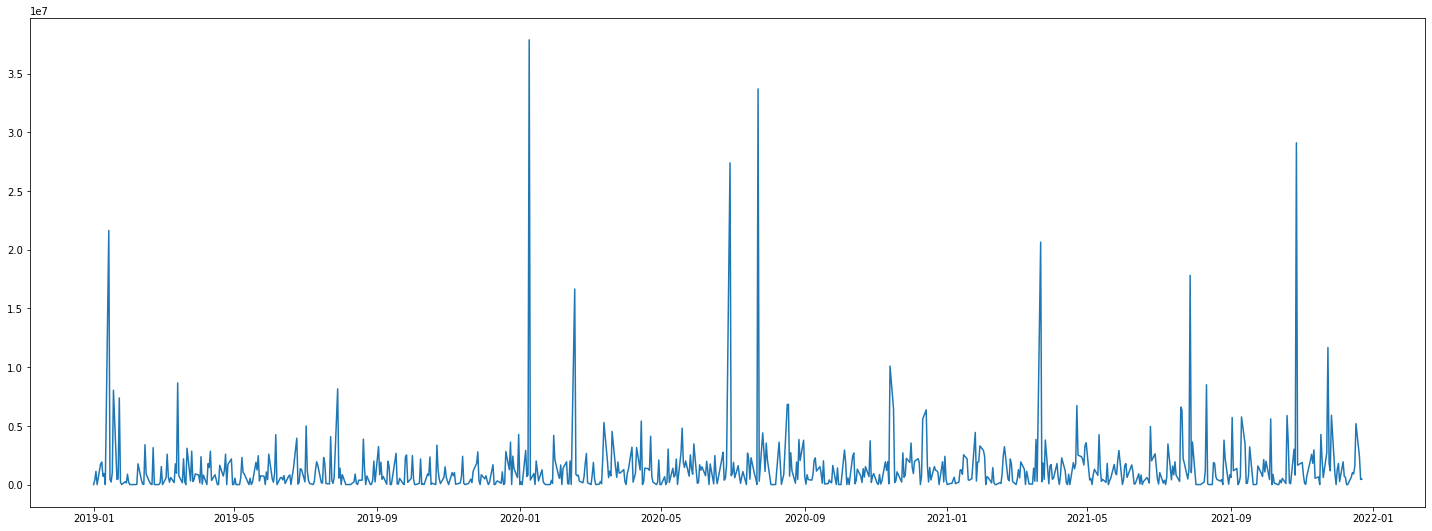

In [77]:
plt.figure(figsize = (25, 9))
plt.plot(df_1170.index,df_1170.y)
plt.show()

In [78]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1170)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"3,570,499",25000000,0,"-1,871,751","5,612,856","3,570,499","3,570,499",0,0,...,"-2,195,270","-2,195,270","-2,195,270","246,649","246,649","246,649",0,0,0,"1,740,515"
775,2021-12-21,"3,571,093",25000000,0,"-2,125,230","4,905,502","3,571,093","3,571,093",0,0,...,"-2,565,554","-2,565,554","-2,565,554","277,200","277,200","277,200",0,0,0,"1,481,208"
776,2021-12-22,"3,571,688",25000000,0,"-2,157,399","5,148,044","3,571,688","3,571,688",0,0,...,"-2,560,416","-2,560,416","-2,560,416","307,498","307,498","307,498",0,0,0,"1,615,060"
777,2021-12-23,"3,572,283",25000000,0,"-1,716,691","5,670,488","3,572,283","3,572,283",0,0,...,"-2,334,328","-2,334,328","-2,334,328","337,379","337,379","337,379",0,0,0,"1,974,945"
778,2021-12-24,"3,572,877",25000000,0,"-1,782,918","5,429,466","3,572,877","3,572,877",0,0,...,"-2,624,707","-2,624,707","-2,624,707","366,682","366,682","366,682",0,0,0,"1,807,547"
779,2021-12-27,"3,574,662",25000000,0,"-1,078,804","6,123,912","3,574,662","3,574,662",0,0,...,"-2,195,270","-2,195,270","-2,195,270","449,547","449,547","449,547",0,0,0,"2,388,283"
780,2021-12-28,"3,575,257",25000000,0,"-1,682,978","5,711,019","3,575,257","3,575,257",0,0,...,"-2,565,554","-2,565,554","-2,565,554","474,981","474,981","474,981",0,0,0,"1,964,944"
781,2021-12-29,"3,575,852",25000000,0,"-1,813,407","5,716,042","3,575,852","3,575,852",0,0,...,"-2,560,416","-2,560,416","-2,560,416","499,082","499,082","499,082",0,0,0,"1,865,965"
782,2021-12-30,"3,576,447",25000000,0,"-1,700,902","5,786,612","3,576,447","3,576,447",0,0,...,"-2,334,328","-2,334,328","-2,334,328","521,716","521,716","521,716",0,0,0,"1,947,899"
783,2021-12-31,"3,577,042",25000000,0,"-2,328,087","5,100,775","3,577,042","3,577,042",0,0,...,"-2,624,707","-2,624,707","-2,624,707","542,757","542,757","542,757",0,0,0,"1,489,962"


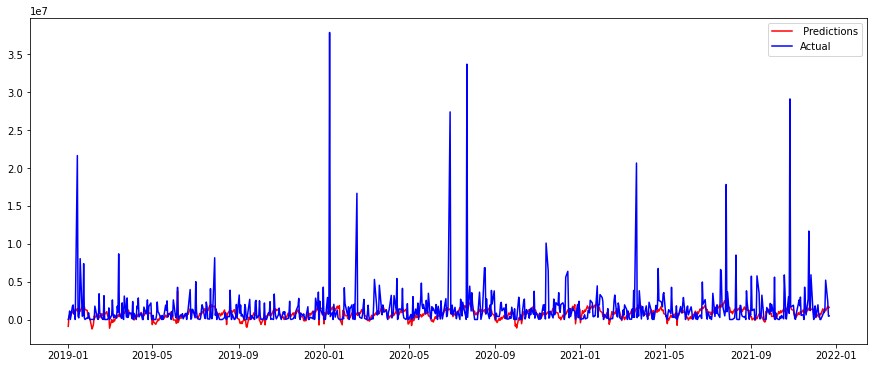

In [79]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1170.index,preds,color='red',label=' Predictions')
plt.plot(df_1170.index,df_1170.y,color='blue',label='Actual')
plt.legend()
plt.show()

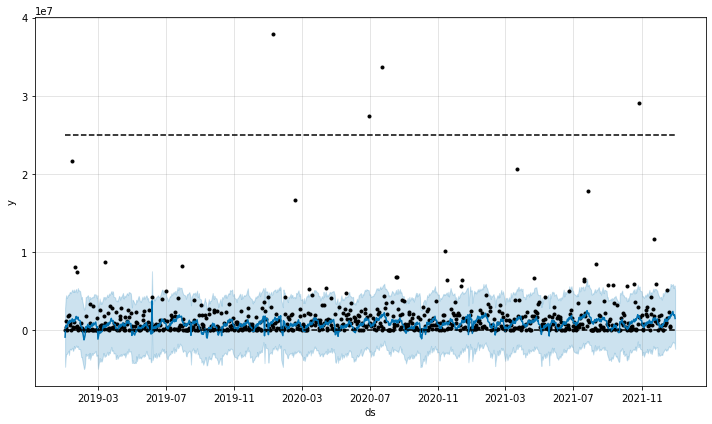

In [80]:
fig = m.plot(m.predict(future))

In [81]:
r2 = round(r2_score(df_1170["y"], preds), 3)
mse = round(mean_squared_error(df_1170["y"], preds), 3)
mae = round(mean_absolute_error(df_1170["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  -0.004
MSE:  8799747496521.621
MAE:  1250507.315


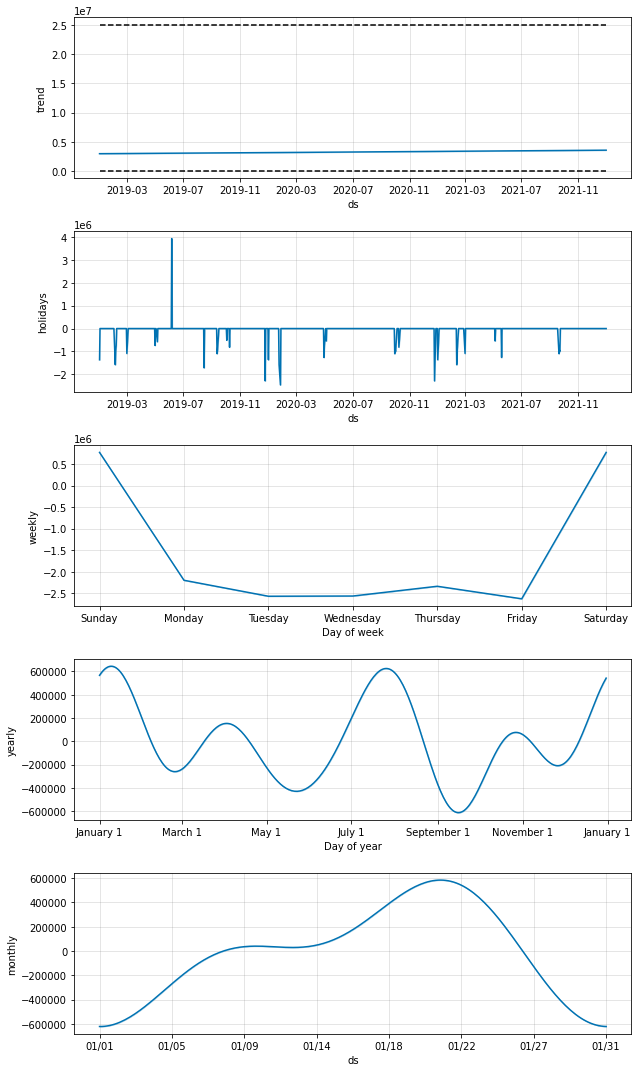

In [82]:
fig = m.plot_components(forecast)

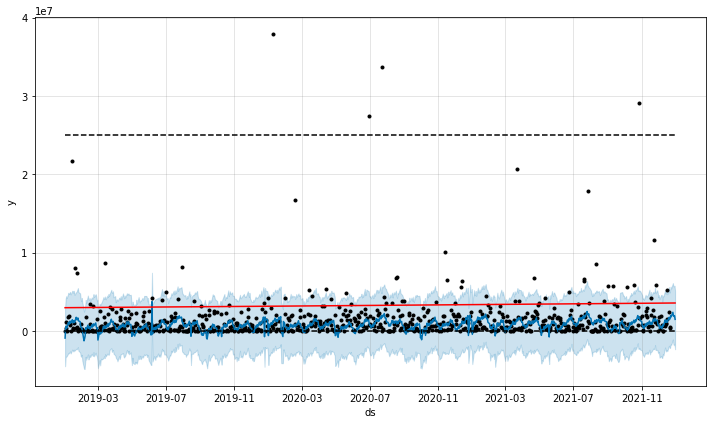

In [83]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [84]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 1,481,208  -2,125,230   4,905,502
776 2021-12-22 1,615,060  -2,157,399   5,148,044
777 2021-12-23 1,974,945  -1,716,691   5,670,488
778 2021-12-24 1,807,547  -1,782,918   5,429,466
779 2021-12-27 2,388,283  -1,078,804   6,123,912
780 2021-12-28 1,964,944  -1,682,978   5,711,019
781 2021-12-29 1,865,965  -1,813,407   5,716,042
782 2021-12-30 1,947,899  -1,700,902   5,786,612
783 2021-12-31 1,489,962  -2,328,087   5,100,775


In [85]:
final_1170 = forecast[['ds', 'yhat']]
final_1170['yhat_1170'] = final_1170['yhat']
final_1170 = final_1170[['ds', 'yhat_1170']]
final_1170.head()

,ds,yhat_1170
0,2019-01-01,"-901,416"
1,2019-01-02,"403,812"
2,2019-01-03,"615,630"
3,2019-01-04,"363,091"
4,2019-01-07,"1,110,173"


In [86]:
#Noksan
df_1180 = df[['date','1180']]
df_1180['ds'] = pd.to_datetime(df_1180['date'])
df_1180['y'] = df_1180['1180']
df_1180 = df_1180.loc[:,['ds', 'y']]
df_1180.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,494970
2,2019-01-03,0
3,2019-01-04,440400
4,2019-01-05,0


In [87]:
df_1180['ds'] = pd.to_datetime(df_1180['ds'])
df_1180 = df_1180[df_1180['ds'].dt.dayofweek < 5]
df_1180['date_index'] = df_1180['ds']
df_1180 = df_1180.set_index('date_index')
df_1180['cap'] = 30000000
df_1180['floor'] = 0
df_1180.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,494970,30000000,0
2019-01-03,2019-01-03,0,30000000,0
2019-01-04,2019-01-04,440400,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,187000,30000000,0
2019-01-09,2019-01-09,1038360,30000000,0
2019-01-10,2019-01-10,0,30000000,0
2019-01-11,2019-01-11,572780,30000000,0


In [88]:
from datetime import datetime
df_1180 = df_1180[datetime(2019, 1, 1):datetime(2021, 12, 22)]

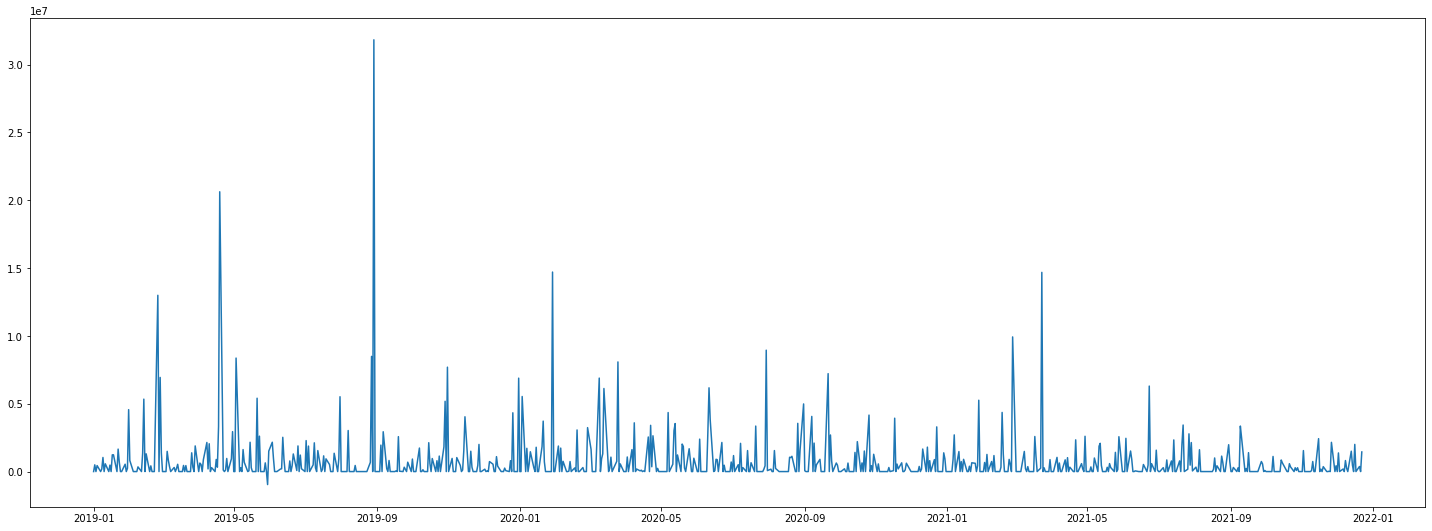

In [89]:
plt.figure(figsize = (25, 9))
plt.plot(df_1180.index,df_1180.y)
plt.show()

In [90]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1180)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 10000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"5,489",10000000,0,"-2,251,617","3,034,205","5,489","5,489",0,0,...,"632,543","632,543","632,543","-253,044","-253,044","-253,044",0,0,0,"276,150"
775,2021-12-21,"5,502",10000000,0,"-2,085,502","3,053,398","5,502","5,502",0,0,...,"756,135","756,135","756,135","-244,598","-244,598","-244,598",0,0,0,"431,044"
776,2021-12-22,"5,516",10000000,0,"-1,754,567","3,476,774","5,516","5,516",0,0,...,"963,359","963,359","963,359","-235,460","-235,460","-235,460",0,0,0,"691,133"
777,2021-12-23,"5,529",10000000,0,"-1,875,001","3,330,590","5,529","5,529",0,0,...,"965,041","965,041","965,041","-225,640","-225,640","-225,640",0,0,0,"766,714"
778,2021-12-24,"5,542",10000000,0,"-1,913,871","3,341,170","5,542","5,542",0,0,...,"795,076","795,076","795,076","-215,151","-215,151","-215,151",0,0,0,"687,182"
779,2021-12-27,"5,582",10000000,0,"-1,910,036","3,323,799","5,582","5,582",0,0,...,"632,543","632,543","632,543","-179,878","-179,878","-179,878",0,0,0,"804,945"
780,2021-12-28,"5,595",10000000,0,"-1,561,193","3,476,576","5,595","5,595",0,0,...,"756,135","756,135","756,135","-166,937","-166,937","-166,937",0,0,0,"989,379"
781,2021-12-29,"5,608",10000000,0,"-1,253,423","3,696,459","5,608","5,608",0,0,...,"963,359","963,359","963,359","-153,458","-153,458","-153,458",0,0,0,"1,226,393"
782,2021-12-30,"5,622",10000000,0,"-1,365,869","3,760,485","5,622","5,622",0,0,...,"965,041","965,041","965,041","-139,477","-139,477","-139,477",0,0,0,"1,222,896"
783,2021-12-31,"5,635",10000000,0,"-1,567,852","3,581,876","5,635","5,635",0,0,...,"795,076","795,076","795,076","-125,035","-125,035","-125,035",0,0,0,"1,013,392"


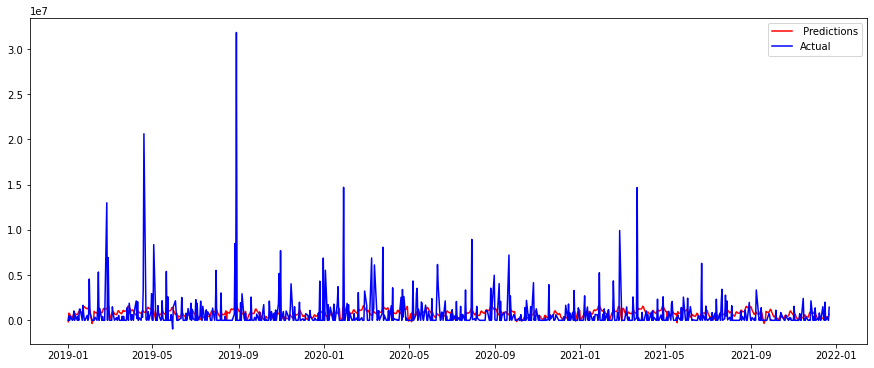

In [91]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1180.index,preds,color='red',label=' Predictions')
plt.plot(df_1180.index,df_1180.y,color='blue',label='Actual')
plt.legend()
plt.show()

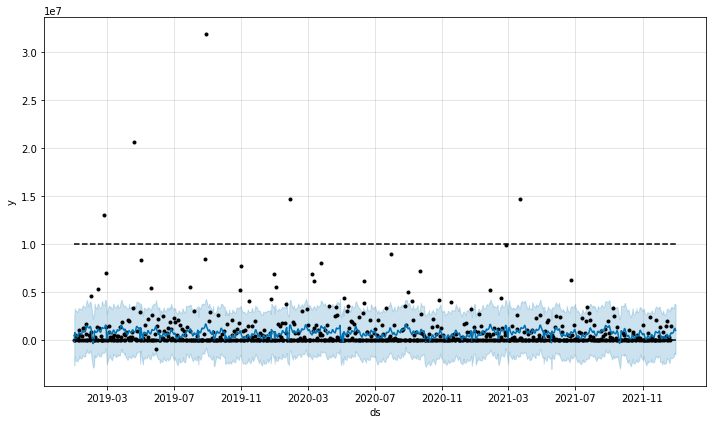

In [92]:
fig = m.plot(m.predict(future))

In [93]:
r2 = round(r2_score(df_1180["y"], preds), 3)
mse = round(mean_squared_error(df_1180["y"], preds), 3)
mae = round(mean_absolute_error(df_1180["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.033
MSE:  4070118474082.549
MAE:  994934.24


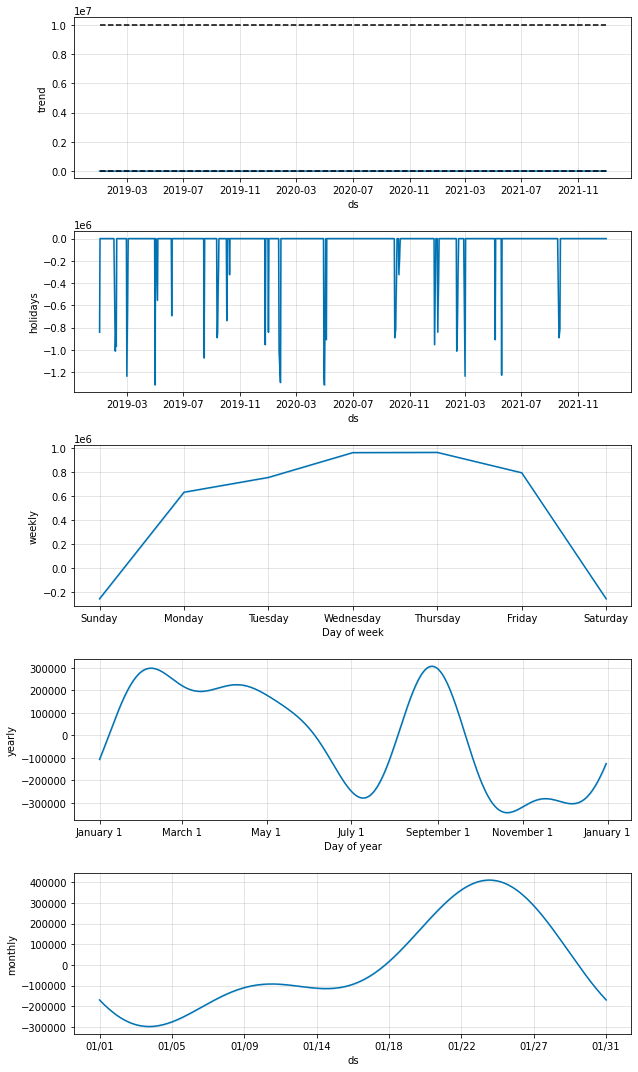

In [94]:
fig = m.plot_components(forecast)

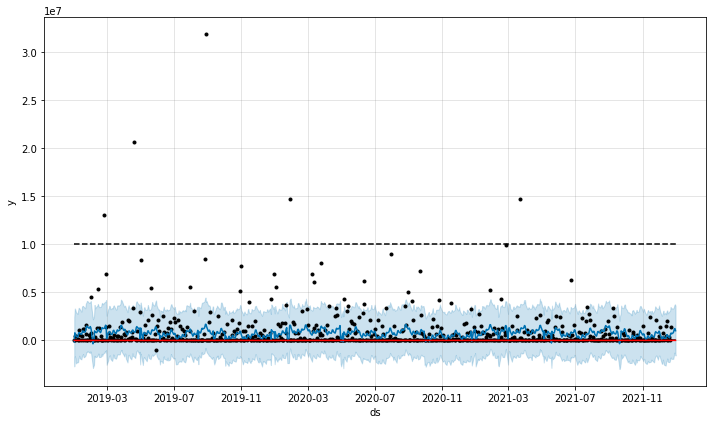

In [95]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [96]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21   431,044  -2,085,502   3,053,398
776 2021-12-22   691,133  -1,754,567   3,476,774
777 2021-12-23   766,714  -1,875,001   3,330,590
778 2021-12-24   687,182  -1,913,871   3,341,170
779 2021-12-27   804,945  -1,910,036   3,323,799
780 2021-12-28   989,379  -1,561,193   3,476,576
781 2021-12-29 1,226,393  -1,253,423   3,696,459
782 2021-12-30 1,222,896  -1,365,869   3,760,485
783 2021-12-31 1,013,392  -1,567,852   3,581,876


In [97]:
final_1180 = forecast[['ds', 'yhat']]
final_1180['yhat_1180'] = final_1180['yhat']
final_1180 = final_1180[['ds', 'yhat_1180']]
final_1180.head()

,ds,yhat_1180
0,2019-01-01,"-162,533"
1,2019-01-02,"791,266"
2,2019-01-03,"713,011"
3,2019-01-04,"486,982"
4,2019-01-07,"328,821"


In [98]:
final_1110['date_index'] = final_1110['ds']
final_1110 = final_1110.set_index('date_index')

final_1120['date_index'] = final_1120['ds']
final_1120 = final_1120.set_index('date_index')

final_1140['date_index'] = final_1140['ds']
final_1140 = final_1140.set_index('date_index')

final_1150['date_index'] = final_1150['ds']
final_1150 = final_1150.set_index('date_index')

final_1160['date_index'] = final_1160['ds']
final_1160 = final_1160.set_index('date_index')

final_1170['date_index'] = final_1170['ds']
final_1170 = final_1170.set_index('date_index')

final_1180['date_index'] = final_1180['ds']
final_1180 = final_1180.set_index('date_index')

In [99]:
final_1110.dtypes

ds           datetime64[ns]
yhat_1110           float64
dtype: object

In [100]:
final_total = pd.merge(final_1110, final_1120)
final_total = pd.merge(final_total, final_1140)
final_total = pd.merge(final_total, final_1150)
final_total = pd.merge(final_total, final_1160)
final_total = pd.merge(final_total, final_1170)
final_total = pd.merge(final_total, final_1180)
final_total.tail()

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180
779,2021-12-27,"6,606,223","1,226,060","1,550,159","1,138,801","3,428,705","2,388,283","804,945"
780,2021-12-28,"5,907,093","1,724,446","2,624,938","1,187,516","3,353,545","1,964,944","989,379"
781,2021-12-29,"6,832,374","1,945,189","2,331,177","1,461,615","2,760,966","1,865,965","1,226,393"
782,2021-12-30,"6,894,974","1,795,387","2,199,333","2,040,987","2,729,479","1,947,899","1,222,896"
783,2021-12-31,"9,245,717","2,318,132","2,125,376","1,226,566","2,531,429","1,489,962","1,013,392"


In [101]:
final_total['final_sum'] = final_total['yhat_1110'] + final_total['yhat_1120'] + final_total['yhat_1140'] + final_total['yhat_1150'] + final_total['yhat_1160'] +final_total['yhat_1170'] + final_total['yhat_1180']

In [102]:
final_total.tail(7)

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180,final_sum
777,2021-12-23,"5,031,169","1,201,544","2,018,542","1,514,874","2,650,700","1,974,945","766,714","15,158,488"
778,2021-12-24,"7,939,197","1,823,353","1,977,916","648,732","2,911,108","1,807,547","687,182","17,795,035"
779,2021-12-27,"6,606,223","1,226,060","1,550,159","1,138,801","3,428,705","2,388,283","804,945","17,143,177"
780,2021-12-28,"5,907,093","1,724,446","2,624,938","1,187,516","3,353,545","1,964,944","989,379","17,751,862"
781,2021-12-29,"6,832,374","1,945,189","2,331,177","1,461,615","2,760,966","1,865,965","1,226,393","18,423,680"
782,2021-12-30,"6,894,974","1,795,387","2,199,333","2,040,987","2,729,479","1,947,899","1,222,896","18,830,955"
783,2021-12-31,"9,245,717","2,318,132","2,125,376","1,226,566","2,531,429","1,489,962","1,013,392","19,950,574"
